In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Load data
import pickle
with open("../data/stock_monthly.dat", "rb") as file:
    y, T, T_num, _, _ = pickle.load(file)
Tmax = np.max(T)
print(Tmax)
T = T/Tmax
# Load model result
with open("../outcome/stock_monthly/Adam/reg_100/lb_0/phi_s20.5phi_l0.05/stock_res.pickle", "rb") as res:
    theta, Z, mu, L, m, s, phi = pickle.load(res)

337.0


In [4]:
def Cov_mat(theta, X1, X2 = None, error=1e-5):
        # theta = variance + scale parameters. parameters are all under log scale.
        sigmaf2= theta[0]
        _X2 = X1 if X2 is None else X2
        # guarantee X1 is a two-dimensional array
        if len(X1.shape) == 0:
            X1 = np.array([[X1]])
        if len(X1.shape) == 1:
            X1 = np.reshape(X1, [-1, 1])
        if len(_X2.shape) == 0:
            _X2 = np.array([[_X2]])
        if len(_X2.shape) == 1:
            _X2 = np.reshape(_X2, [-1, 1])
        #l: Automatic relevance determination
        l = theta[(theta.shape[0]-X1.shape[1]):]
        dist = np.matmul(np.reshape(np.sum((X1/l)**2,1), [-1,1]), np.reshape(np.ones(_X2.shape[0]), [1,-1])) + np.matmul(np.reshape(np.ones(X1.shape[0]), [-1,1]), np.reshape(np.sum((_X2/l)**2,1), [1,-1])) - 2*np.matmul((X1/l), np.transpose(_X2/l))
        cov_mat = sigmaf2 * np.exp(-dist/2.0)
        if X2 is None:
            # To guarantee the robustness of matrix inversion, we add epsilion on the diagonal.
            cov_mat += np.diag(np.ones(X1.shape[0]))*error
        return cov_mat


def pred_f(X, Z, U, theta):
    Cov_MM_inv = np.linalg.inv(Cov_mat(theta, Z))
    Cov_Mn = Cov_mat(theta, Z, X)
    Cov_nM = Cov_Mn.T
    A = np.matmul(Cov_nM, Cov_MM_inv)
    mean = np.matmul(A, U.reshape([-1, 1]))
    return mean.reshape([-1])

def softmax(x):
        """Compute softmax values for each matrix."""
        if len(x.shape) == 2:
            e_x = np.exp(x - np.max(x, axis=1).reshape(-1,1)*np.ones([1, x.shape[1]]))
            return (e_x / np.sum(e_x, axis = 1).reshape(-1,1)*np.ones([1, x.shape[1]]))
        if len(x.shape) == 1:
            e_x = np.exp(x - np.max(x))
            return e_x/np.sum(e_x)

# EDA
N, T_max, D = y.shape
K = [5,5,5]
Q = 2
n_s = 1
# for d in range(D):
#     fig = plt.figure()
#     for n in range(n_s):
#         plt.plot(T[n, :T_num[n]], y[n, :T_num[n], d])
#     plt.show()

# fig = plt.figure()
# for q in range(Q):
#     for n in range(n_s):
#         plt.plot(T[n, :T_num[n]], m[n, :T_num[n], q])
#     plt.show()

# Classify the return rate using y
labels = np.array([[sum(y[n,t,:])//5 for t in range(T_max)] for n in range(N)])
np.unique(labels)

# Predict the outputs based on latent space.
n_grids = 200
grids_x = np.linspace(-5,5,n_grids)
grids_y = np.linspace(-5,5,n_grids)
xv, yv = np.meshgrid(grids_x, grids_y, indexing='ij')
# predict zv
zv = np.zeros([n_grids, n_grids, D])
for ind_x in range(n_grids):
    if ind_x % 10 == 0:
        print(ind_x)
    for ind_y in range(n_grids): 
        zv[ind_x, ind_y, :] = np.array([np.argmax(softmax(np.array([pred_f(np.array([grids_x[ind_x], grids_y[ind_y]]).reshape([1,-1]), Z, mu[:, d, k], theta[d, :]) for k in range(K[d])]).T), axis=1) for d in range(D)]).reshape([-1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


zv.shape = (200, 200, 3)
zv_cat.shape = (200, 200)


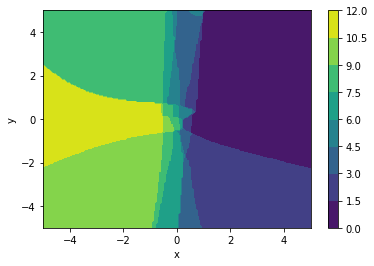

In [7]:
print("zv.shape = {}".format(zv.shape))
zv_cat = np.array([[sum(zv[ind_x, ind_y, :]) for ind_y in range(n_grids)] for ind_x in range(n_grids)])
print("zv_cat.shape = {}".format(zv_cat.shape))
fig = plt.figure()
plt.contourf(xv,yv,zv_cat)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()
# fig.savefig("../outcome/stock/latent.png")

In [8]:
def predict_latent_process(ind, verbose=False, error = 1e-5):
    # Predict the latent process for individual patient
    grids = np.linspace(0,1, Tmax)
    n_grids = grids.shape[0]
    quan = np.zeros([n_grids, Q, 3])
    for q in range(Q):
        #print('Cov_MM: ', self.Cov_mat(self.est_phi[q,:], self.y_t[patient_ind,:self.T[patient_ind]]))
        for i in range(n_grids):
            Cov_MM_inv = np.linalg.inv(Cov_mat(phi[q,:], T[ind,:T_num[ind]]))
            Cov_Mn = Cov_mat(phi[q,:], T[ind,:T_num[ind]], grids[i])
            Cov_nM = Cov_Mn.T
            A = np.matmul(Cov_nM, Cov_MM_inv)
            mean = np.matmul(A, m[ind,:T_num[ind], q].reshape([-1,1]))[0,0]
            sd = np.sqrt(np.max([error, phi[q,0] - np.matmul(A, Cov_Mn)[0,0]]))
            quan[i, q, :] = np.array([mean-1.96*sd, mean, mean+1.96*sd])
    return quan

/home/oem/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


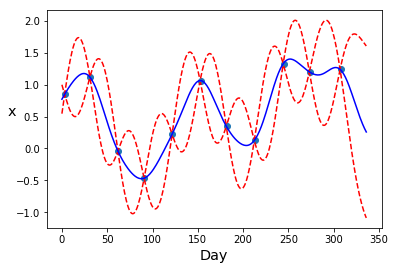

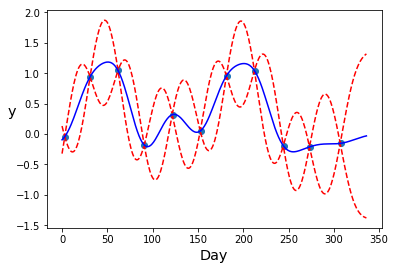

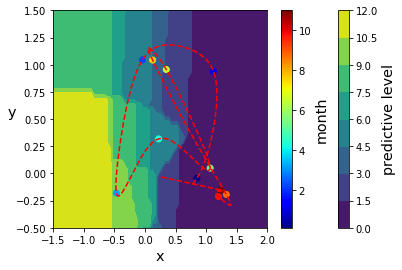

In [25]:
ind = 2008-1965
quan = predict_latent_process(ind)
# plot latent process under each dimension
labels = ['x', 'y']
for q in range(Q):
    fig = plt.figure()
    plt.scatter(T[ind,:T_num[ind]]*Tmax, m[ind,:T_num[ind], q])
    plt.plot(quan[:,q,[0,2]], "r--")
    plt.plot(quan[:,q,1], "b")
    plt.xlabel('Day', fontsize = "x-large")
    plt.ylabel(labels[q], rotation = "horizontal", size = "x-large")
    fig.savefig("../outcome/stock_monthly/year{}_D{}.png".format(ind + 1965, q))
fig = plt.figure()
plt.contourf(xv,yv,zv_cat)
plt.xlabel('x')
plt.ylabel('y')
cb = plt.colorbar()
cb.set_label('predictive level', size = "x-large")
plt.plot(quan[:, 0, 1], quan[:, 1, 1], 'r--')
plt.scatter(m[ind,:,0], m[ind,:,1], c = T[ind,:]*12, cmap = plt.cm.jet)
cb = plt.colorbar()
cb.set_label('month', size = "x-large")
plt.xlim([-1.5,2])
plt.ylim([-0.5,1.5])
plt.xlabel("x", size = "x-large")
plt.ylabel("y", size = "x-large", rotation = "horizontal")
plt.show()
fig.savefig("../outcome/stock_monthly/year{}_trace.png".format(ind + 1965, q))

/home/rui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


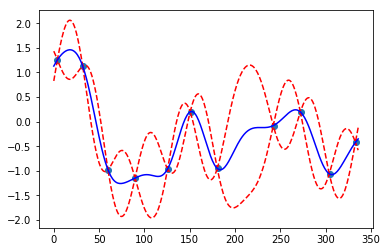

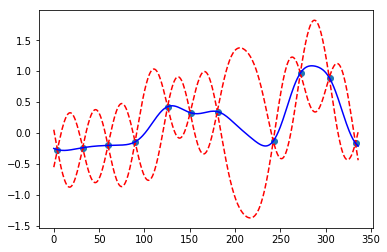

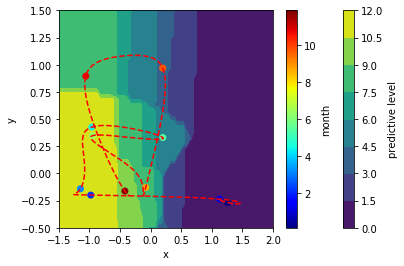

In [17]:
ind = 2009-1965
quan = predict_latent_process(ind)
# plot latent process under each dimension
for q in range(Q):
    fig = plt.figure()
    plt.scatter(T[ind,:T_num[ind]]*Tmax, m[ind,:T_num[ind], q])
    plt.plot(quan[:,q,[0,2]], "r--")
    plt.plot(quan[:,q,1], "b")
    plt.show()
    fig.savefig("outcome/stock_monthly/year{}_D{}.png".format(ind + 1965, q))
fig = plt.figure()
plt.contourf(xv,yv,zv_cat)
plt.xlabel('x')
plt.ylabel('y')
cb = plt.colorbar()
cb.set_label('predictive level')
plt.plot(quan[:, 0, 1], quan[:, 1, 1], 'r--')
plt.scatter(m[ind,:,0], m[ind,:,1], c = T[ind,:]*12, cmap = plt.cm.jet)
cb = plt.colorbar()
cb.set_label('month')
plt.xlim([-1.5, 2])
plt.ylim([-0.5, 1.5])
plt.show()
fig.savefig("outcome/stock_monthly/year{}_trace.png".format(ind + 1965, q))